## CM3 Baltic salinity

In [1]:
import matplotlib.pyplot as plt
import xarray as xr, numpy as np
import cartopy.crs as ccrs
from pathlib import Path

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)

In [3]:
def annual_mean(ds, original_time_axis=False):
    """ Properly month length weighted annual mean of a DataArray"""
    if not ds.time.dt.month[0] == 1:
        raise ValueError("Data does not start with January")
    if not ds.time.dt.month[1] == 2:
        raise ValueError("Non-monthly data")
    # Process only complete years
    nmon = 12*(len(ds.time)//12)
    month_length = ds.time.dt.days_in_month[:nmon]
    # Eventually use weighted ??? https://github.com/pydata/xarray/issues/3937
    weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    ann_mean = (ds[:nmon]*weights).groupby('time.year').sum(dim='time',min_count=1)
    if original_time_axis:
        ann_mean = ann_mean.assign_coords({'year':ds[:nmon].time.groupby('time.year').mean(dim='time')})
    return ann_mean

In [4]:
dgrid = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/mom/grids/mosaic/global.25km/2025.05.15/ocean_hgrid.nc')
# Subsample supergrid
geolat_t = dgrid.y[1::2,1::2].rename({'nyp':'yh', 'nxp':'xh'})
geolon_t = dgrid.x[1::2,1::2].rename({'nyp':'yh', 'nxp':'xh'})

In [5]:
dir = Path('/scratch/tm70/kr4383/cylc-run/cm3-run-11-08-2025-25km-beta-om3-new-um-params')
dstatic = xr.open_dataset(dir / 'work/19810101/atmos/access-cm3.mom6.h.static.nc')
wet = dstatic.wet
mask = xr.where(wet==1.0, 0., np.nan)
areacello = xr.where(wet==1.0, dstatic.areacello, 0.)
ocean_vol = (dstatic['deptho']*areacello).sum().values
ocean_area = areacello.sum().values
ocean_density = 1026.
# These have missing values
# geolon = dstatic.geolon
# geolat = dstatic.geolat

/jobfs/151882409.gadi-pbs/ipykernel_1516538/4152052103.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  dstatic = xr.open_dataset(dir / 'work/19810101/atmos/access-cm3.mom6.h.static.nc')


In [6]:
reqd = ['sos', 'somint']

def _preprocess(d):
    return xr.Dataset({v:d[v] for v in reqd})

files = sorted(dir.glob('work/*/atmos/access-cm3.mom6.h.native_*.nc'))
sos = xr.open_mfdataset(files, preprocess=_preprocess, decode_timedelta=False).sos
sos = sos.assign_coords({'geolat_t':geolat_t, 'geolon_t':geolon_t})
somint = xr.open_mfdataset(files, preprocess=_preprocess, decode_timedelta=False).somint
somint = somint.assign_coords({'geolat_t':geolat_t, 'geolon_t':geolon_t})


In [7]:
sos_a = annual_mean(sos).compute()
somint_a = annual_mean(somint).compute()

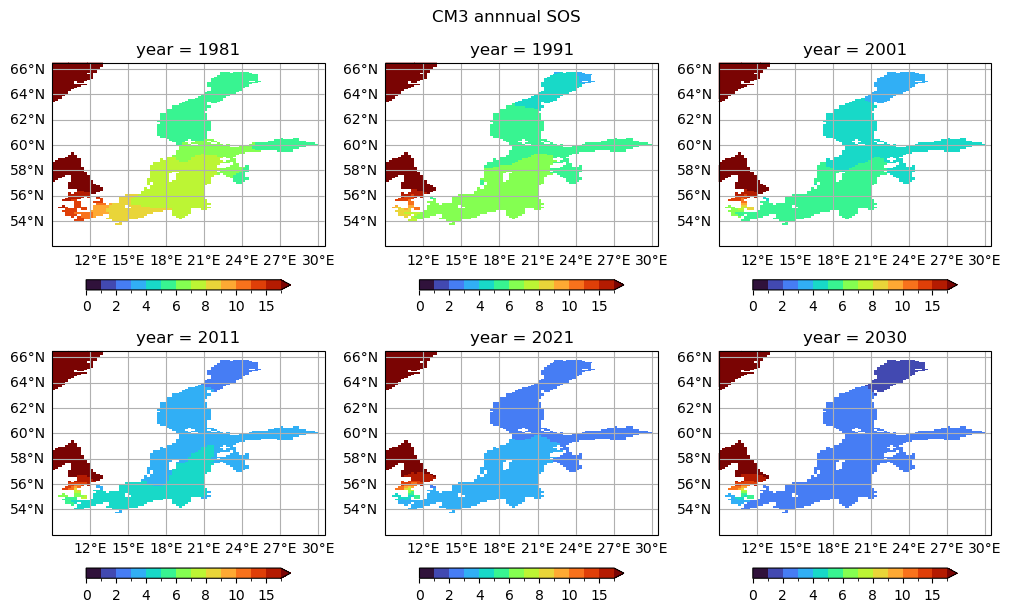

In [8]:
fig, axes = plt.subplots(2,3,layout='constrained', figsize=(10,6),
  subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
fig.suptitle('CM3 annnual SOS')
axes = axes.flat
for i, y in enumerate([0, 10, 20, 30, 40, -1]):
    ax = axes[i]

    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False

    ax.set_extent((9, 30.5, 52, 66.5))
    levels=[0,1,2,3,4,5,6,7,8,9,10,12,15,20]
    cbar_kwargs = {'shrink':0.75, 'orientation':'horizontal'}
    p1 = sos_a[y].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.cm.turbo,
                     x='geolon_t',y='geolat_t', levels=levels, cbar_kwargs=cbar_kwargs)

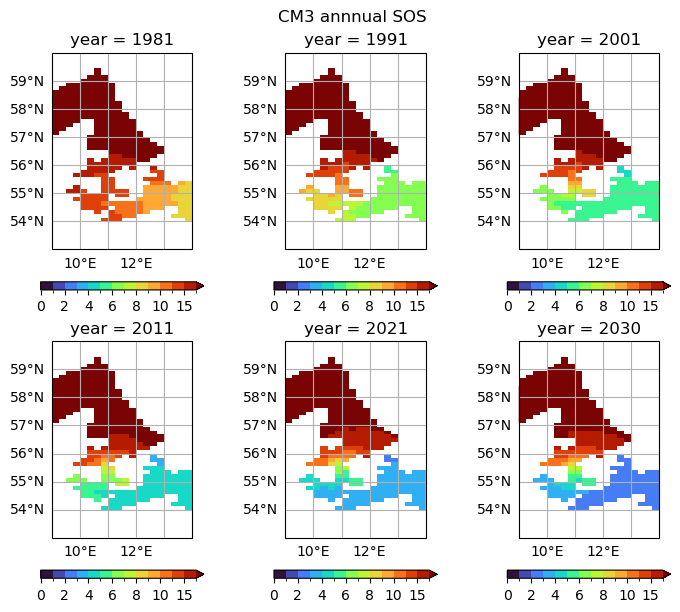

In [ ]:
fig, axes = plt.subplots(2,3,layout='constrained', figsize=(7,6),
  subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
fig.suptitle('CM3 annnual SOS')
axes = axes.flat
for i, y in enumerate([0, 10, 20, 30, 40, -1]):
    ax = axes[i]

    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False

    ax.set_extent((9, 14, 53, 60))
    levels=[0,1,2,3,4,5,6,7,8,9,10,12,15,20]
    cbar_kwargs = {'shrink':0.75, 'orientation':'horizontal'}
    sos_a[y].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.cm.turbo,
                     x='geolon_t',y='geolat_t', levels=levels, cbar_kwargs=cbar_kwargs)

In [9]:
# For the Baltic with edge at 14 E
baltic_xslice = slice(1174,1242)
baltic_yslice = slice(810,915)

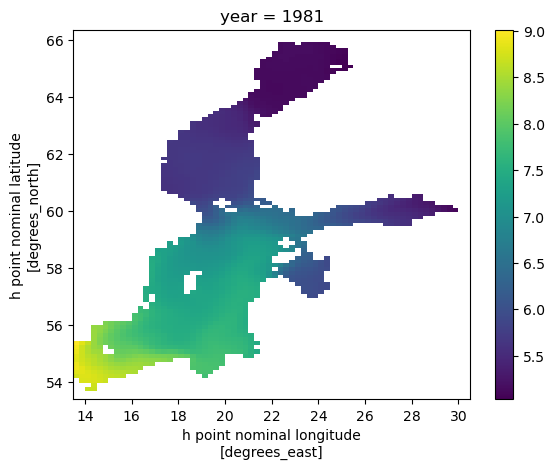

In [10]:
# sos_a[0,810:915,1174:1242].plot()
sos_a[0,baltic_yslice,baltic_xslice].plot()

In [11]:
sos_baltic = sos[:,baltic_yslice,baltic_xslice] * areacello[baltic_yslice,baltic_xslice]
baltic_area = areacello[baltic_yslice,baltic_xslice].sum(('xh', 'yh'))
sos_baltic = (sos_baltic.sum(('xh', 'yh')) / baltic_area).compute()
sos_baltic_min = sos[:,baltic_yslice,baltic_xslice].min(('xh', 'yh')).compute()

Text(0.5, 1.0, 'Baltic surface salinity')

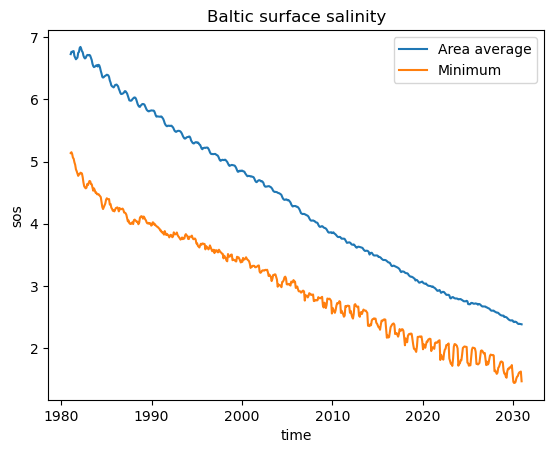

In [12]:
fig, axes = plt.subplots()
sos_baltic.plot(label='Area average')
sos_baltic_min.plot(label='Minimum')
axes.legend()
axes.set_title('Baltic surface salinity')

In [13]:
# somint is PSU kg/m^2 ~ g/kg/m^2 of salt, so salt mass in kg/m^2 ~ somint * 1e-3
total_salt_baltic = somint_a[:,baltic_yslice,baltic_xslice] * areacello[baltic_yslice,baltic_xslice]
total_salt_baltic = 1e-3*total_salt_baltic.sum(('xh', 'yh')).compute()

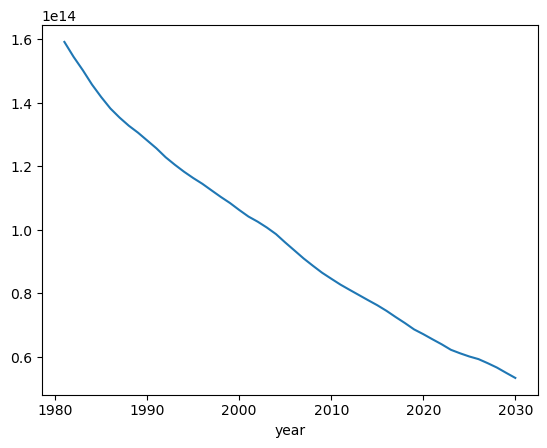

In [14]:
total_salt_baltic.plot()

Text(0, 0.5, 'kg/s')

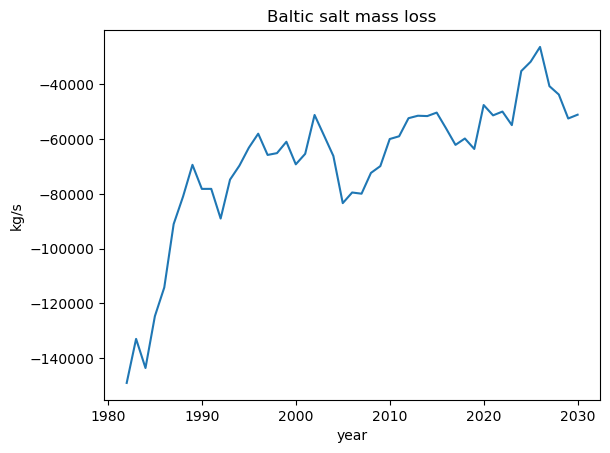

In [15]:
fig, axes = plt.subplots()
# To get kg/s
(total_salt_baltic.diff('year')/(365*86400)).plot()
axes.set_title('Baltic salt mass loss')
axes.set_ylabel('kg/s')